In [ ]:
!pip install gymnasium matplotlib numpy
!pip install optuna


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 18.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.2 MB/s eta 0:00:00


In [ ]:
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import optuna
from gym import make


In [ ]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }

    def __init__(self):

        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 10
        self.state_finder = {(0,0):0,(0,1):1,(0,2):2,(0,3):3,(1,0):4,(1,1):5,(1,2):6,(1,3):7,(2,0):8,(2,1):9,(2,2):10,(2,3):11,(3,0):12,(3,1):13,(3,2):14,(3,3):15}
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.bigbomb_pos = [2,0]
        self.smallbomb_pos = [1,2]
        self.bigreward_pos = [2,3]
        self.smallreward_pos = [3,1]
        self.state = np.zeros((4,4))
        self.graph_state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.bigbomb_pos)] = -5
        self.state[tuple(self.smallbomb_pos)] = -3
        self.state[tuple(self.bigreward_pos)] = 7
        self.state[tuple(self.smallreward_pos)] = 4


    def reset(self, **kwargs):

        self.state = np.zeros((4,4))
        self.agent_pos = [0, 0]
        self.timestep = 0
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.bigbomb_pos)] = 0
        self.state[tuple(self.smallbomb_pos)] = 0
        self.state[tuple(self.bigreward_pos)] = 0
        self.state[tuple(self.smallreward_pos)] = 0
        self.state[tuple(self.agent_pos)] = 1

        observation = self.state.flatten()

        self.graph_state = np.zeros((4,4))
        self.graph_state[tuple(self.goal_pos)] = self.state[tuple(self.agent_pos)]
        self.graph_state[tuple(self.bigbomb_pos)] = -5
        self.graph_state[tuple(self.smallbomb_pos)] = -3
        self.graph_state[tuple(self.bigreward_pos)] = 7
        self.graph_state[tuple(self.smallreward_pos)] = 4
        self.graph_state[tuple(self.agent_pos)] = self.state[tuple(self.agent_pos)]

        reset_state = self.state_finder[tuple(self.agent_pos)]

        return reset_state,observation

    def step(self, action):

        if action == 0:
          self.agent_pos[0] += 1
        if action == 1:
          self.agent_pos[0] -= 1
        if action == 2:
          self.agent_pos[1] += 1
        if action == 3:
          self.agent_pos[1] -= 1

        # Comment this to demonstrate the truncation condition.
        self.agent_pos = np.clip(self.agent_pos, 0, 3)

        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.bigbomb_pos)] = 0
        self.state[tuple(self.smallbomb_pos)] = 0
        self.state[tuple(self.bigreward_pos)] = 0
        self.state[tuple(self.smallreward_pos)] = 0
        if self.timestep == self.max_timesteps-1:
          self.state[tuple(self.agent_pos)] = 2
        else:
          self.state[tuple(self.agent_pos)] = 1

        observation = self.state.flatten()

        #for graph after plot after observation
        self.graph_state = np.zeros((4,4))
        self.graph_state[tuple(self.goal_pos)] = self.state[tuple(self.goal_pos)]
        self.graph_state[tuple(self.bigbomb_pos)] = -5
        self.graph_state[tuple(self.smallbomb_pos)] = -3
        self.graph_state[tuple(self.bigreward_pos)] = 7
        self.graph_state[tuple(self.smallreward_pos)] = 4
        self.graph_state[tuple(self.agent_pos)] = self.state[tuple(self.agent_pos)]


        next_state = self.state_finder[tuple(self.agent_pos)]

        reward = 0
        if np.array_equal(self.agent_pos, self.goal_pos):
          reward = 10
        elif np.array_equal(self.agent_pos, self.bigbomb_pos):
          reward = -5
        elif np.array_equal(self.agent_pos, self.smallbomb_pos):
          reward = -3
        elif np.array_equal(self.agent_pos, self.bigreward_pos):
          reward = 7
        elif np.array_equal(self.agent_pos, self.smallreward_pos):
          reward = 4

        self.timestep += 1

        terminated = True if self.timestep >= self.max_timesteps else False
        truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 3)) else False

        return next_state,reward, observation,terminated, truncated

    def render(self):
        plt.close()
        fig, ax = plt.subplots()
        ax.imshow(self.graph_state)
        #Rendering goal state
        plt.text(self.goal_pos[1], self.goal_pos[0]-0.4, "Goal" , ha='center', va='center', color='black')
        final_icon = plt.imread('/content/trophy.png')
        final_icon_img = OffsetImage(final_icon, zoom=0.15)
        final_icon_artist = AnnotationBbox(final_icon_img, (self.goal_pos[1], self.goal_pos[0]), xycoords='data', frameon=False)
        ax.add_artist(final_icon_artist)

        #Rendering agent state
        plt.text(self.agent_pos[1], self.agent_pos[0]-0.4, "Player" , ha='center', va='center', color='black')
        player_icon = plt.imread('/content/mario.png')
        player_icon_img = OffsetImage(player_icon, zoom=0.15)
        player_icon_artist = AnnotationBbox(player_icon_img, (self.agent_pos[1], self.agent_pos[0]), xycoords='data', frameon=False)
        ax.add_artist(player_icon_artist)

        #Rendering big reward
        plt.text(self.bigreward_pos[1]+0.4, self.bigreward_pos[0]+0.4, "+7" , ha='center', va='center', color='black')
        bigreward_icon = plt.imread('/content/bigreward.png')
        bigreward_icon_img = OffsetImage(bigreward_icon, zoom=0.15)
        bigreward_icon_artist = AnnotationBbox(bigreward_icon_img, (self.bigreward_pos[1], self.bigreward_pos[0]), xycoords='data', frameon=False)
        ax.add_artist(bigreward_icon_artist)

        #Rendering small reward
        plt.text(self.smallreward_pos[1]+0.4, self.smallreward_pos[0]+0.4, "+4" , ha='center', va='center', color='black')
        smallreward_icon = plt.imread('/content/smallreward.png')
        smallreward_icon_img = OffsetImage(smallreward_icon, zoom=0.15)
        smallreward_icon_artist = AnnotationBbox(smallreward_icon_img, (self.smallreward_pos[1], self.smallreward_pos[0]), xycoords='data', frameon=False)
        ax.add_artist(smallreward_icon_artist)

        #Rendering big bomb
        plt.text(self.bigbomb_pos[1]+0.4, self.bigbomb_pos[0]+0.4, "-5" , ha='center', va='center', color='black')
        bigbomb_icon = plt.imread('/content/bigbomb.png')
        bigbomb_icon_img = OffsetImage(bigbomb_icon, zoom=0.15)
        bigbomb_icon_artist = AnnotationBbox(bigbomb_icon_img, (self.bigbomb_pos[1], self.bigbomb_pos[0]), xycoords='data', frameon=False)
        ax.add_artist(bigbomb_icon_artist)

        #Rendering smallbomb
        plt.text(self.smallbomb_pos[1]+0.4, self.smallbomb_pos[0]+0.4, "-3" , ha='center', va='center', color='black')
        smallbomb_icon = plt.imread('/content/smallbomb.png')
        smallbomb_icon_img = OffsetImage(smallbomb_icon, zoom=0.15)
        smallbomb_icon_artist = AnnotationBbox(smallbomb_icon_img, (self.smallbomb_pos[1], self.smallbomb_pos[0]), xycoords='data', frameon=False)
        ax.add_artist(smallbomb_icon_artist)


In [ ]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    return np.random.choice(self.action_space.n)

In [ ]:
##Part I = Grid Environment Simulation

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

['Down', 'Up', 'Down', 'Up', 'Right', 'Up', 'Right', 'Up', 'Up', 'Up']


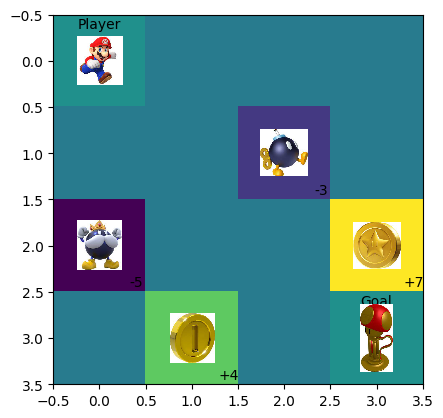

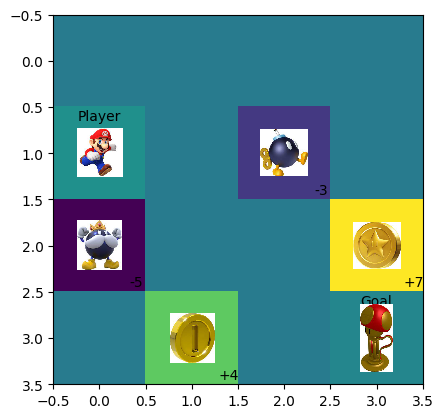

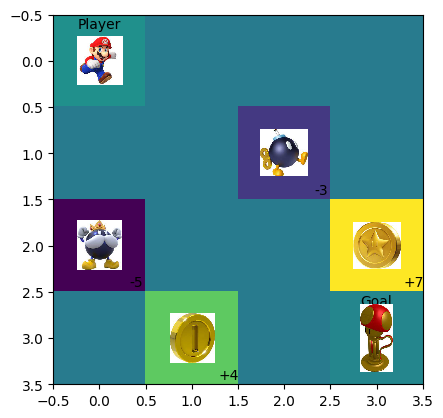

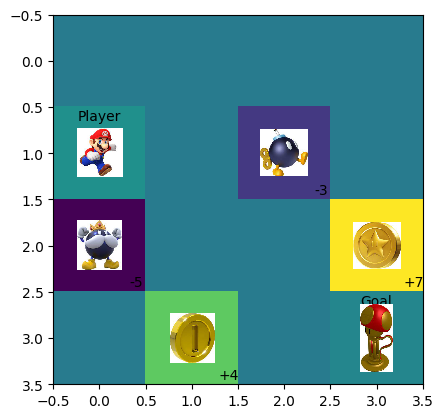

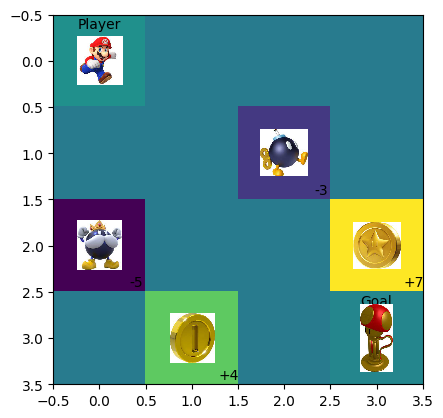

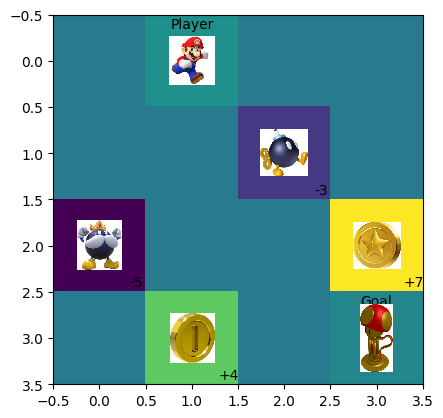

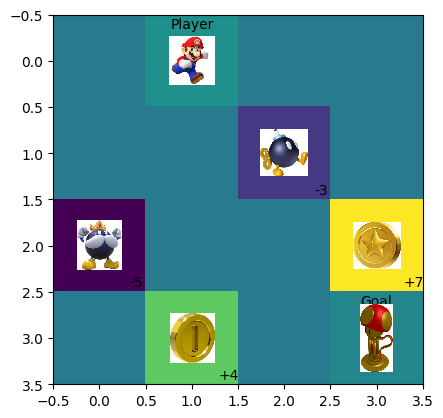

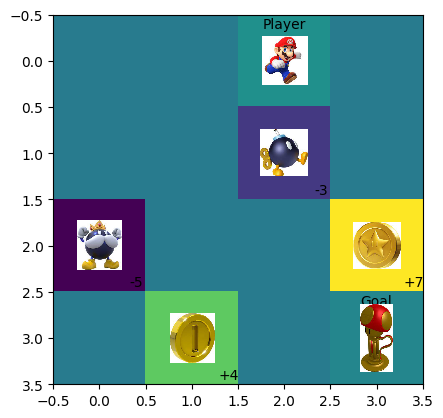

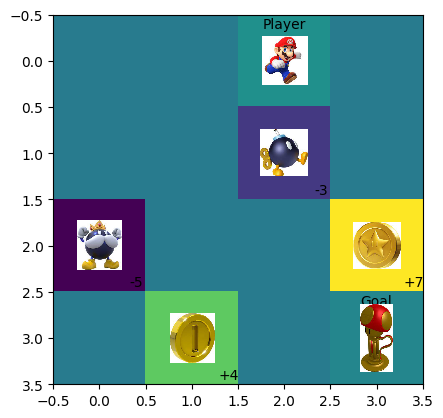

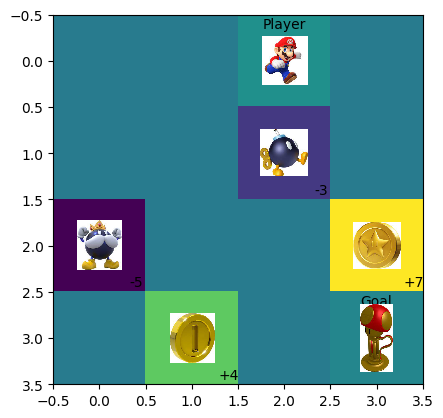

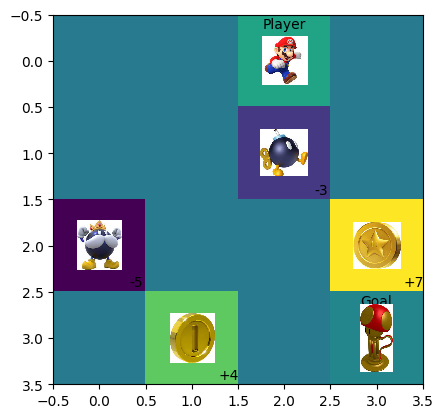

In [ ]:
action_decoder ={0:"Down",1:"Up",2:"Right",3:"Left"}
env = GridEnvironment()
agent = RandomAgent(env)

obs = env.reset()
terminated, truncated = False, False

output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()

actions= []
rewards= []
while not terminated:
  action = agent.step(obs)
  next_state,reward, obs,terminated, truncated = env.step(action)
  actions.append(action)
  rewards.append(reward)
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    plt.figure() #added this line to plot at every step
    env.render()
  time.sleep(1)
print([action_decoder[ac] for ac in actions])

In [ ]:
rewards

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
## Part II - SARSA

In [ ]:
class SARSA:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1,no_of_episodes=1000):
        self.env = env
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor
        self.epsilon = epsilon # exploration rate
        self.episodes= no_of_episodes
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            # Choose a random action with epsilon probability for exploration
            return self.env.action_space.sample()
        else:
            # Choose the action with the highest Q-value
            return np.argmax(self.q_table[state])


    def update_q_table(self, state, action, reward, next_state, next_action):
        current_q = self.q_table[state, action]
        next_q = self.q_table[next_state, next_action]
        td_error = reward + self.gamma * next_q - current_q
        new_q = current_q + self.alpha * td_error
        self.q_table[state, action] = new_q

    def train(self):
      output_grid = widgets.Grid(1, 1)
      all_episodes_reward = []
      for episode in range(self.episodes):
          actions = []
          rewards = []
          state,observation = self.env.reset()
          action = self.choose_action(state)
          actions.append(action)
          terminated = False

          while not terminated:
              next_state, reward, observation,terminated, truncated = self.env.step(action)
              next_action = self.choose_action(next_state)
              # print(next_state,reward,terminated)
              actions.append(next_action)
              rewards.append(reward)
              self.update_q_table(state, action, reward, next_state, next_action)

              state = next_state
              action = next_action
          print(f'{episode} actions:{actions}')
          print(f'{episode} rewards:{rewards}')
          all_episodes_reward.append(rewards)
          print(f'{episode}----observations:{observation}')
          if (episode + 1) % 100 == 0:
              print("Episode: {}, Q-Table: \n{}".format(episode + 1, self.q_table))

      return all_episodes_reward



In [ ]:
def objective(env, trial):
    alpha = trial.suggest_float('alpha', 0.0, 1.0)
    gamma = trial.suggest_float('gamma', 0.0, 1.0)
    epsilon = trial.suggest_float('epsilon', 0.0, 1.0)

    sarsa = SARSA(env, alpha=alpha, gamma=gamma, epsilon=epsilon)
    all_episodes_reward = sarsa.train()
    avg_reward = np.mean([sum(rewards) for rewards in all_episodes_reward])

    return avg_reward

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(env, trial), n_trials=1)

print('Best trial:', study.best_trial.params)


[I 2023-04-28 00:32:30,827] A new study created in memory with name: no-name-fd0d51bb-7862-43c9-a0de-263783691516


""


0 actions:[2, 3, 0, 2, 2, 0, 3, 0, 1, 2, 0]
0 rewards:[0, 0, 0, 0, -3, 0, 0, 4, 0, 0]
0----observations:[1.  1.  0.  0.  1.  1.  0.  0.  0.  1.  2.  0.  0.  0.  0.  0.5]
1 actions:[3, 2, 1, 0, 2, 1, 0, 1, 3, 3, 2]
1 rewards:[0, 0, 0, 0, -3, 0, -3, 0, 0, 0]
1----observations:[2.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]
2 actions:[1, 0, 2, 2, 3, 2, 0, 0, 3, 1, 3]
2 rewards:[0, 0, 0, -3, 0, -3, 0, 0, 4, 0]
2----observations:[1.  0.  0.  0.  1.  1.  0.  0.  0.  2.  1.  0.  0.  0.  1.  0.5]
3 actions:[0, 2, 3, 2, 1, 2, 2, 2, 0, 0, 3]
3 rewards:[0, 0, 0, 0, 0, 0, 0, 0, 0, 7]
3----observations:[1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  0.  2.  0.  0.  0.  0.5]
4 actions:[3, 2, 1, 0, 1, 3, 0, 2, 1, 3, 3]
4 rewards:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4----observations:[2.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]
5 actions:[3, 0, 3, 1, 3, 2, 2, 0, 0, 0, 1]
5 rewards:[0, 0, 0, 0, 0, 0, 0, -3, 0, 0]
5----observations:[1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0

[I 2023-04-28 00:32:33,274] Trial 0 finished with value: -1.239 and parameters: {'alpha': 0.20856735416723193, 'gamma': 0.8951671591460706, 'epsilon': 0.9563675931132191}. Best is trial 0 with value: -1.239.


932 rewards:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
932----observations:[1.  1.  0.  0.  1.  1.  0.  0.  0.  1.  2.  0.  0.  0.  0.  0.5]
933 actions:[0, 1, 1, 0, 0, 3, 1, 3, 3, 2, 2]
933 rewards:[0, 0, 0, 0, -5, -5, 0, 0, 0, 0]
933----observations:[1.  0.  0.  0.  1.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]
934 actions:[2, 1, 1, 3, 1, 2, 2, 3, 1, 1, 0]
934 rewards:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
934----observations:[1.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]
935 actions:[3, 0, 0, 2, 2, 0, 2, 1, 3, 3, 0]
935 rewards:[0, 0, -5, 0, 0, 0, 10, 7, 0, 0]
935----observations:[1.  0.  0.  0.  1.  0.  0.  0.  0.  2.  1.  0.  0.  0.  1.  0.5]
936 actions:[2, 3, 2, 1, 2, 3, 3, 0, 0, 3, 2]
936 rewards:[0, 0, 0, 0, 0, 0, 0, 0, -5, -5]
936----observations:[1.  1.  1.  0.  1.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.5]
937 actions:[1, 3, 1, 0, 2, 3, 3, 1, 3, 3, 0]
937 rewards:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
937----observations:[2.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0. 

In [ ]:
no_of_episodes = 1000

In [ ]:
env = GridEnvironment()
agent = SARSA(env,2)


In [ ]:
all_rewards = agent.train()


In [ ]:
all_rewards

In [ ]:
episodes = [i for i in range(1,no_of_episodes+1)]
episodes[-1]
len(episodes)
len(all_rewards)

In [ ]:
# plt.scatter(episodes,all_rewards)

plt.figure(figsize=(15,5))
plt.xlabel('Episode')
plt.ylabel('Reward Value')
plt.title('Rewards Per Episode (Training)')
plt.yticks([-10,-7,-5,-3,0,3,5,7,10])
plt.xticks([100,200,300,400,500,600,700,800,900,1000])

for i in range(len(all_rewards[0])):
    plt.scatter(episodes,[pt[i] for pt in all_rewards])
plt.legend()
plt.show()

# plt.ylim(ymin=-102, ymax=102)
# plt.xlim(xmin=0, xmax=500)
# plt.grid()
# plt.show()

In [ ]:
#is plotting each grid required ? no
#should Q-table updation stop with reaching terminal state ?no...just print out converged there
#check truncate condition
#rewardgraph -done
#pass epsilon value and append into list
#epsilon graph
#come with test function : Last priority
